## Import

In [17]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

from train import fit, test_multi_classification
from utils import plot_fit_result
from driver_monitor_model import DriverMonitorModel
from data_processing import generate_csv, create_sq_data, split_scenarios, create_df_fn
from metrics import plot_confusion_matrix

## Data 전처리

In [2]:
# 예시 디렉토리 경로 설정
dirname = r"C:\classes\4th deeplearning project\datsets1\Training\keypoints"

# 이미지 좌표 추출, 시나리오 구분, 라벨링, 클래스별 CSV 파일 생성
generate_csv(dirname, num_sample = 290) 

>>>>>>>>>>>>>>>>>>>>>모든 이미지 인식에 성공한 normal[0] scenario 폴더 수 : 290개
>>>>>>>>>>>>>>>>>>>>>모든 이미지 인식에 성공한 little drowsy[1] scenario 폴더 수 : 290개
>>>>>>>>>>>>>>>>>>>>>모든 이미지 인식에 성공한 drowsy[2] scenario 폴더 수 : 290개
CSV 파일 생성 완료.


In [3]:
# DataFrame 로드 및 확인 
df_0_normal = pd.read_csv("scenario_df/scn_0_normal.csv")
df_1_little_drowsy = pd.read_csv("scenario_df/scn_1_little drowsy.csv")
df_2_drowsy = pd.read_csv("scenario_df/scn_2_drowsy.csv")
print(f"클래스별 이미지 개수 : normal {len(df_0_normal)} 장 || little drowsy- {len(df_1_little_drowsy)} 장 || drowsy - {len(df_2_drowsy)} 장")
print("="*70)

# CSV 파일 로드 및 데이터 프레임 생성
# drowsy_scn, yawning_scn, phone_scn, smoke_scn, normal_scn = split_scenarios(dirname)
combined_df = pd.concat([
    df_0_normal,
    df_1_little_drowsy,
    df_2_drowsy
], ignore_index=True)
print(f"전체 이미지 개수 : {len(combined_df)} 장")
print("="*70)

# 데이터 프레임을 통한 sequential 데이터 생성
data_X, data_y = create_sq_data(combined_df, time_steps=5)
print("시퀀셜 데이터 생성 완료")
print(f"data_X.shape : {data_X.shape}")
print(f"data_y.shape : {data_y.shape}")

클래스별 이미지 개수 : normal 7250 장 || little drowsy- 7250 장 || drowsy - 7250 장
전체 이미지 개수 : 21750 장
시퀀셜 데이터 생성 완료
data_X.shape : (16531, 5, 136)
data_y.shape : (16531,)


## 모델 학습

In [5]:
# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(data_X, data_y, test_size = 0.2, random_state = 0, stratify = data_y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,test_size = 0.5, random_state = 0, stratify = y_temp)

# 정규화 (trainset의 평균과 표준편차 이용)
# X_train 정규화
X_train_mean = np.mean(X_train, axis = 0) 
X_train_std = np.std(X_train, axis = 0)
X_train_scaled =(X_train - X_train_mean)  / X_train_std

# X_valid 정규화 
X_valid_scaled = (X_valid - X_train_mean) / X_train_std
# X_test 정규화
X_test_scaled = (X_test - X_train_mean) / X_train_std

# Tensor 변환
X_train_tensor =torch.tensor(X_train_scaled, dtype= torch.float32)
X_valid_tensor = torch.tensor(X_valid_scaled, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset 생성
train_set = TensorDataset(X_train_tensor, y_train_tensor)
valid_set = TensorDataset(X_valid_tensor, y_valid_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader 생성
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size = 32)
test_loader = DataLoader(test_set, batch_size = 32)

In [6]:
# Dataloader 생성 확인, step 수 확인
len(train_loader), len(valid_loader), len(test_loader)

(206, 52, 52)

In [7]:
# 하이퍼 파라미터
EPOCHS = 1000
LR = 0.001
INPUT_SIZE = 136
HIDDEN_SIZE = 5
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT_RATE = 0.2


# 모델 생성
model = DriverMonitorModel(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, 
    dropout_rate=DROPOUT_RATE
)

In [ ]:
# 모델 학습 준비
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용을 원하면 'cuda'로 변경
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
save_path = "models/driver_monitor_model.pth"


# 모델 학습
train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = fit(train_loader, valid_loader, model, loss_fn, optimizer, EPOCHS,
                                                                                  save_best_model=True, save_model_path=save_path,
                                                                                  early_stopping = True, patience=50, device=device,
                                                                                  mode='multi', lr_scheduler=None)

# 학습이 끝난 후 가장 좋은 모델을 저장합니다
torch.save(model.state_dict(), "models/driver_monitor_model.pth")

# train 결과 폴더 생성
output_folder = "train_results"
os.makedirs(output_folder, exist_ok=True)


# 결과 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
unique_filename = f"training_log_{timestamp}.txt"
output_file = os.path.join(output_folder, unique_filename)

params = {
    "EPOCHS": EPOCHS,
    "LR": LR,
    "INPUT_SIZE": INPUT_SIZE,
    "HIDDEN_SIZE": HIDDEN_SIZE,
    "NUM_LAYERS": NUM_LAYERS,
    "BIDIRECTIONAL": BIDIRECTIONAL,
    "DROPOUT_RATE": DROPOUT_RATE
}

with open(output_file, "w") as f:
    f.write("Hyperparameters:\n")
    for key, value in params.items():
        f.write(f"{key}: {value}\n")
    
    f.write("\nTraining and validation results:\n")
    for epoch in range(EPOCHS):
        if epoch % 10 == 0 or epoch == EPOCHS-1:
            if epoch < len(train_loss_list):
                f.write(f"Epoch {epoch + 1}:\n")
                f.write(f"  Train Loss: {train_loss_list[epoch]}\n")
                f.write(f"  Train Accuracy: {train_accuracy_list[epoch]}\n")
                f.write(f"  Validation Loss: {valid_loss_list[epoch]}\n")
                f.write(f"  Validation Accuracy: {valid_accuracy_list[epoch]}\n")

# 결과 그래프 저장
unique_plot_filename = f"training_results_{timestamp}.png"
save_path =os.path.join(output_folder, unique_plot_filename)
plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list, save_path)
plt.show()

print("Training complete. Results saved in:", output_file)

## 모델 검증

Test Loss: 0.4016
Test Accuracy: 0.8410


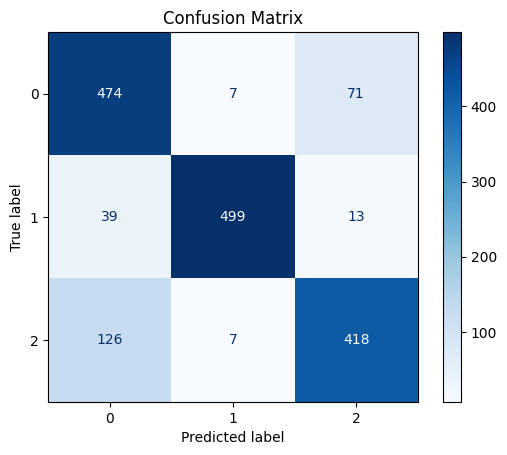

Classification Report:
              precision    recall  f1-score   support

      normal       0.74      0.86      0.80       552
     yawning       0.97      0.91      0.94       551
      drowsy       0.83      0.76      0.79       551

    accuracy                           0.84      1654
   macro avg       0.85      0.84      0.84      1654
weighted avg       0.85      0.84      0.84      1654



In [14]:
# 모델 로드
model = DriverMonitorModel(
    input_size=136, hidden_size=5,
    num_layers=2, bidirectional=True, 
    dropout_rate=0.2
)
model.load_state_dict(torch.load("models/driver_monitor_model.pth"))
loss_fn = nn.CrossEntropyLoss()

#테스트 데이터 평가
test_loss, test_accuracy, predictions, true_labels = test_multi_classification(test_loader, model, loss_fn, device=device)

# 손실과 정확도 출력
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix 출력
# 폴더 생성
test_output = "train_results"
os.makedirs(test_output, exist_ok=True)
plot_confusion_matrix(true_labels, predictions, test_output,"Confusion Matrix")

# 분류 보고서 출력
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['normal', 'yawning', 'drowsy']))

# 모델 적용 
## Webcam으로 실시간 영상 추론

In [15]:
import cv2
import numpy as np
import torch
import pandas as pd
import pickle
from PIL import Image, ImageFont
import mediapipe as mp
from driver_monitor_model import DriverMonitorModel


# 모델 로드
model = DriverMonitorModel(
    input_size=136, hidden_size=5,
    num_layers=2, bidirectional=True, 
    dropout_rate=0.2
)

model.load_state_dict(torch.load("models/driver_monitor_model.pth"))
model.eval()  # 모델을 evaluation 모드로 설정

# Mediapipe Face Mesh 모델 설정
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
)

# 사용할 얼굴 keypoints 인덱스
landmark_points_68 = [162, 234, 93, 58, 172, 136, 149, 148, 152, 377, 378, 365, 397, 288, 323, 454, 389, 71, 63, 105, 66, 107, 336,
                      296, 334, 293, 301, 168, 197, 5, 4, 75, 97, 2, 326, 305, 33, 160, 158, 133, 153, 144, 362, 385, 387, 263, 373,
                      380, 61, 39, 37, 0, 267, 269, 291, 405, 314, 17, 84, 181, 78, 82, 13, 312, 308, 317, 14, 87]

# 클래스 레이블
class_names = ["Normal", "Little Drowsy", "Drowsy"]

In [16]:
# 비디오 캡처 시작
cap = cv2.VideoCapture(0)
fps = cap.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
frame_count = 0
frame_xy_list = []  # 모든 프레임의 keypoints 누적 리스트
pred_class = ""
proba_max = 0.0

while cap.isOpened():
    succ, frame = cap.read()  # 프레임 읽기

    if succ:
        frame = cv2.flip(frame, 1)  # 화면 좌우 반전
        image_height, image_width, _ = frame.shape
        frame_count += 1

        # 얼굴 keypoints 검출
        results = face_mesh.process(frame)
        
        # 얼굴 keypoints 좌표 추출
        frame_kp_list = []
        if results.multi_face_landmarks:
            for idx, landmark in enumerate(results.multi_face_landmarks[0].landmark):
                if idx in landmark_points_68:
                    x = landmark.x
                    y = landmark.y
                    cv2.circle(frame, (int(x * image_width), int(y * image_height)), 2, (255, 0, 0), -1)
                    frame_kp_list.append((x, y))

            # 144 프레임마다 keypoints 데이터 수집
            if frame_count % 144 == 0:
                frame_xy_list.append(frame_kp_list)
                frame_xy_np = np.array(frame_xy_list)
                x_df = pd.DataFrame(frame_xy_np[:, :, 0])  # x 좌표
                y_df = pd.DataFrame(frame_xy_np[:, :, 1])  # y 좌표
                current_df = pd.concat([x_df, y_df], axis=1, ignore_index=True)
    
            # 최소 5프레임 데이터가 쌓이면 sequence 생성해 예측 수행
            if len(frame_xy_list) >= 5:
                data_X = current_df.iloc[-5:].values  # 마지막 5프레임 데이터
                data_X = (data_X - X_train_mean) / X_train_std  # 학습 데이터 기반으로 정규화
                data_X = torch.tensor(data_X, dtype=torch.float32).unsqueeze(dim=0)
                
                with torch.no_grad():
                    pred = model(data_X)
                    proba = torch.softmax(pred, dim=1)
                    proba_max, proba_idx = proba.max(dim=1)
                    pred_class = class_names[proba_idx.item()]
    
            # 화면에 예측 결과 표시
            if pred_class: # 처음 720초 (144*5동안은 detecting 표시)
                cv2.putText(frame, f"{pred_class} - {proba_max.item():.2f}%", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            else: 
                cv2.putText(frame, "Detecting...", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2,lineType=cv2.LINE_AA) # 영상 위에 그리기(프레임 단위로  새로운 값)


        # 화면에 프레임 표시
        cv2.imshow("Frame", frame)
    
        # ESC 키를 누르면 종료
        if cv2.waitKey(1) == 27:
            break

    else:
        break

# 비디오 캡처 종료
cap.release()
cv2.destroyAllWindows()